# Educational Notebook: PoissonGAM for Precipitation Modeling

## Objective
This notebook demonstrates the use of Poisson Generalized Additive Models (GAMs) for modeling precipitation data. We'll explore why PoissonGAM is appropriate for count data, prepare the data, fit models to individual years, and interpret the results.

## Learning Goals
- Understand when PoissonGAM is appropriate for count data
- Learn to prepare precipitation data for Poisson modeling
- Fit PoissonGAM models with spline terms
- Interpret results and perform diagnostics
- Compare year-to-year variations in seasonal patterns



## Section 1: Introduction

### Theoretical Background

**Poisson Distribution**: The Poisson distribution is appropriate for modeling count data, where:
- The outcome is a non-negative integer (0, 1, 2, ...)
- Events occur independently
- The mean and variance are approximately equal (λ ≈ Var)

**Log Link Function**: PoissonGAM uses a log link, meaning:
- We model log(μ) = f(x), where μ is the expected count
- This ensures predictions are always positive
- Back-transformation: μ = exp(f(x))

**When to Use PoissonGAM**:
- Modeling counts of events (e.g., wet days, number of occurrences)
- Data has many zeros or is right-skewed
- Natural count interpretation (cannot have negative values)
- Mean and variance are roughly equal

**When NOT to Use PoissonGAM**:
- Continuous outcomes (use LinearGAM or GammaGAM)
- Overdispersion (variance >> mean) - consider NegativeBinomialGAM
- Binary outcomes (use LogisticGAM)



In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pygam import PoissonGAM, s
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")



Libraries imported successfully!


## Section 2: Data Loading

We'll load the weather data from Parquet format and select a station with multiple years of precipitation data.


In [2]:
!ls ../../../weather_data/stations_weather_with_dist2coast.parquet


part.0.parquet	 part.27.parquet  part.44.parquet  part.61.parquet
part.10.parquet  part.28.parquet  part.45.parquet  part.62.parquet
part.11.parquet  part.29.parquet  part.46.parquet  part.63.parquet
part.12.parquet  part.2.parquet   part.47.parquet  part.64.parquet
part.13.parquet  part.30.parquet  part.48.parquet  part.65.parquet
part.14.parquet  part.31.parquet  part.49.parquet  part.66.parquet
part.15.parquet  part.32.parquet  part.4.parquet   part.67.parquet
part.16.parquet  part.33.parquet  part.50.parquet  part.68.parquet
part.17.parquet  part.34.parquet  part.51.parquet  part.69.parquet
part.18.parquet  part.35.parquet  part.52.parquet  part.6.parquet
part.19.parquet  part.36.parquet  part.53.parquet  part.70.parquet
part.1.parquet	 part.37.parquet  part.54.parquet  part.71.parquet
part.20.parquet  part.38.parquet  part.55.parquet  part.72.parquet
part.21.parquet  part.39.parquet  part.56.parquet  part.73.parquet
part.22.parquet  part.3.parquet   part.57.parquet  part.7.parquet

In [3]:
# Load data from Parquet
import dask.dataframe as dd

file_path = "../../../weather_data/stations_weather_with_dist2coast.parquet"
df = dd.read_parquet(file_path)

# Filter for precipitation data
prcp_df = df[df['ELEMENT'] == 'PRCP'].compute()

print(f"Total PRCP records: {len(prcp_df)}")
print(f"Stations: {prcp_df['ID'].nunique()}")
print(f"Years: {prcp_df['year'].nunique()}")
print(f"Year range: {prcp_df['year'].min()} - {prcp_df['year'].max()}")

# Select a station with multiple years of data
station_counts = prcp_df.groupby('ID')['year'].nunique().sort_values(ascending=False)
selected_station = station_counts.index[0]
station_data = prcp_df[prcp_df['ID'] == selected_station].copy()

print(f"\nSelected station: {selected_station}")
print(f"Station name: {station_data['name'].iloc[0]}")
print(f"Years available: {sorted(station_data['year'].unique())}")
print(f"Number of years: {len(station_data)}")



Total PRCP records: 2443678
Stations: 119952
Years: 73
Year range: 1950 - 2025

Selected station: USW00023062
Station name: DENVER-STAPLETON
Years available: [1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2022, 2023, 2024, 2025]
Number of years: 73


## Section 3: Exploratory Data Analysis

Let's examine the precipitation data to understand its distribution and characteristics.


In [4]:
# Extract daily precipitation values
day_cols = [col for col in station_data.columns if col.startswith('day_')]
day_cols.sort(key=lambda x: int(x.split('_')[1]))  # Sort by day number

# Reshape to long format: one row per day
daily_data = []
for idx, row in station_data.iterrows():
    year = row['year']
    for day_idx, day_col in enumerate(day_cols, start=1):
        value = row[day_col]
        if pd.notna(value):
            daily_data.append({
                'year': year,
                'day_of_year': day_idx,
                'precipitation': value
            })

daily_df = pd.DataFrame(daily_data)
print(f"Total daily observations: {len(daily_df)}")
print(f"\nBasic statistics:")
print(daily_df['precipitation'].describe())

# Zero analysis
num_zeros = (daily_df['precipitation'] == 0).sum()
frac_zeros = num_zeros / len(daily_df)
print(f"\nZero precipitation days: {num_zeros} ({frac_zeros:.2%})")

# Wet-day counts per year
wet_days_per_year = daily_df.groupby('year').apply(
    lambda x: (x['precipitation'] > 0).sum()
)
print(f"\nWet days per year:")
print(wet_days_per_year.describe())



Total daily observations: 26497

Basic statistics:
count    26497.000000
mean        10.693060
std         42.225735
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       1643.000000
Name: precipitation, dtype: float64

Zero precipitation days: 20251 (76.43%)

Wet days per year:
count     73.000000
mean      85.561644
std       14.810832
min       55.000000
25%       77.000000
50%       85.000000
75%       97.000000
max      124.000000
dtype: float64


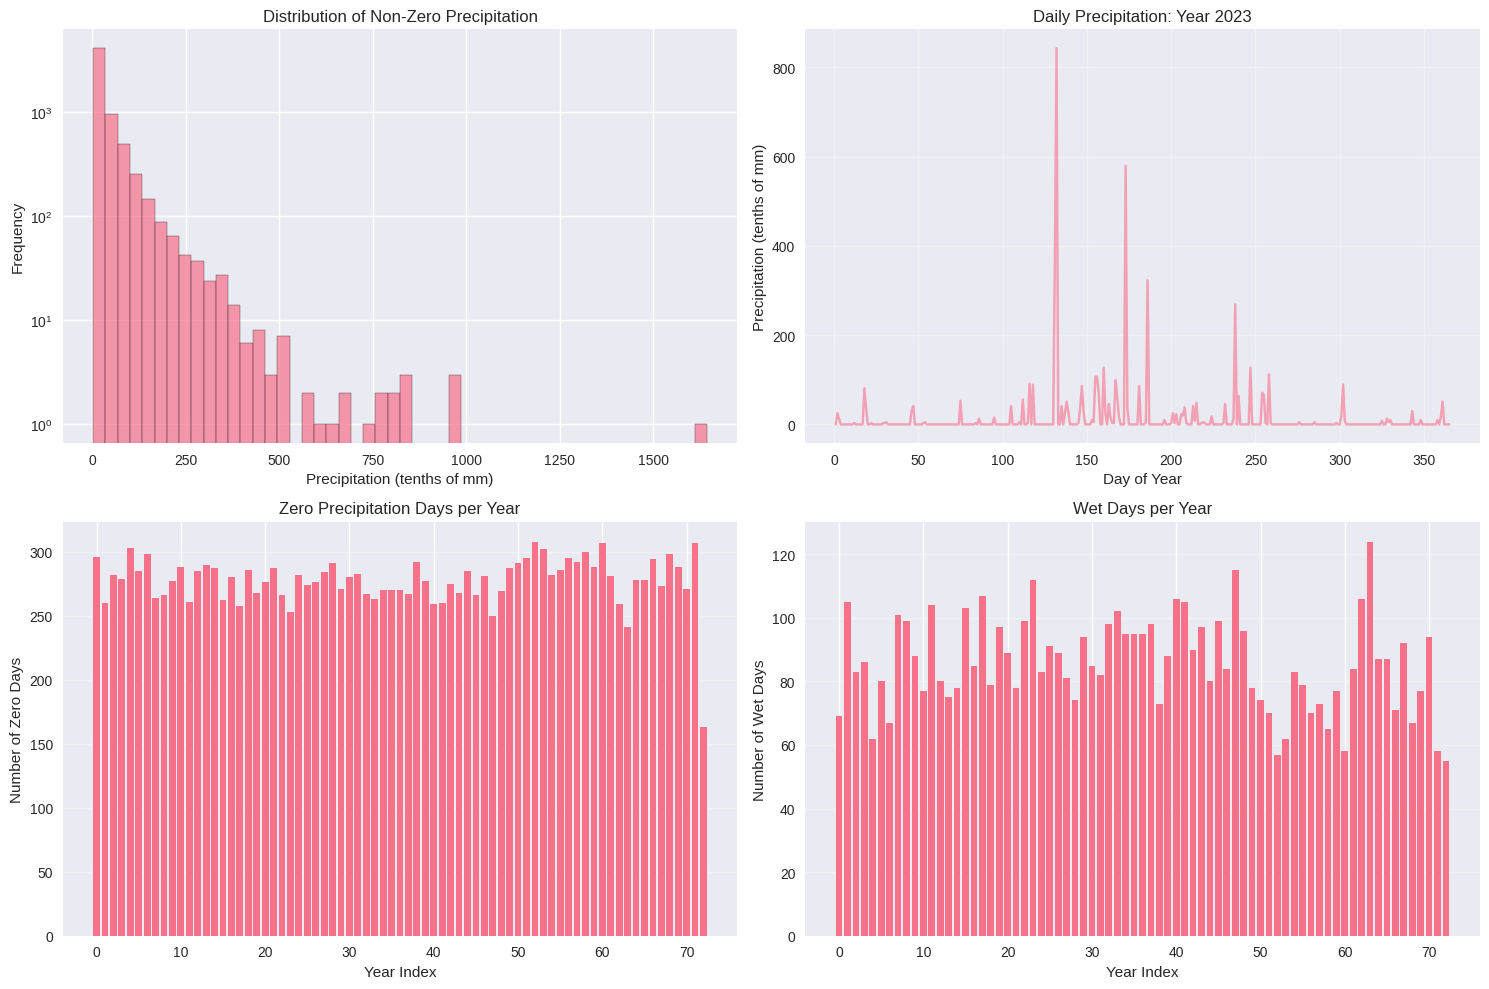

In [5]:
# Visualization: Histogram and time series
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram of precipitation amounts
axes[0, 0].hist(daily_df[daily_df['precipitation'] > 0]['precipitation'], 
                bins=50, edgecolor='k', alpha=0.7)
axes[0, 0].set_xlabel('Precipitation (tenths of mm)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Non-Zero Precipitation')
axes[0, 0].set_yscale('log')

# Time series for one year
sample_year = daily_df['year'].iloc[0]
year_data = daily_df[daily_df['year'] == sample_year].sort_values('day_of_year')
axes[0, 1].plot(year_data['day_of_year'], year_data['precipitation'], alpha=0.6)
axes[0, 1].set_xlabel('Day of Year')
axes[0, 1].set_ylabel('Precipitation (tenths of mm)')
axes[0, 1].set_title(f'Daily Precipitation: Year {sample_year}')
axes[0, 1].grid(True, alpha=0.3)

# Zero analysis
zero_counts = daily_df.groupby('year').apply(lambda x: (x['precipitation'] == 0).sum())
axes[1, 0].bar(range(len(zero_counts)), zero_counts.values)
axes[1, 0].set_xlabel('Year Index')
axes[1, 0].set_ylabel('Number of Zero Days')
axes[1, 0].set_title('Zero Precipitation Days per Year')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Wet-day counts per year
axes[1, 1].bar(range(len(wet_days_per_year)), wet_days_per_year.values)
axes[1, 1].set_xlabel('Year Index')
axes[1, 1].set_ylabel('Number of Wet Days')
axes[1, 1].set_title('Wet Days per Year')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()



## Section 4: Data Preparation

### Modeling Approach: Wet-Day Counts

We have two main options for modeling precipitation:
1. **Model precipitation amounts** (continuous) - Use GammaGAM or LinearGAM
2. **Model wet-day counts** (counts) - Use PoissonGAM ✓

We'll use **wet-day counts per period** as our outcome. This is a true Poisson process:
- Count of events (wet days) in a given time period
- Natural interpretation: "How many wet days occur in a given period?"
- Appropriate for Poisson distribution


In [6]:
# Transform data: Count wet days per period (e.g., per week or bi-weekly)
# We'll use 2-week periods (approximately monthly resolution)
period_length = 14  # days

# Create period assignments for each day of year
daily_df['period'] = ((daily_df['day_of_year'] - 1) // period_length) + 1
num_periods = daily_df['period'].max()
print(f"Number of periods per year: {num_periods}")

# Count wet days per period per year
wet_day_counts = daily_df.groupby(['year', 'period']).apply(
    lambda x: (x['precipitation'] > 0).sum()
).reset_index(name='wet_day_count')

print(f"\nWet-day count statistics:")
print(wet_day_counts['wet_day_count'].describe())

print(f"\nSample of wet-day counts:")
print(wet_day_counts.head(10))



Number of periods per year: 27

Wet-day count statistics:
count    1963.000000
mean        3.181864
std         2.208093
min         0.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        12.000000
Name: wet_day_count, dtype: float64

Sample of wet-day counts:
   year  period  wet_day_count
0  1950       1              3
1  1950       2              2
2  1950       3              5
3  1950       4              1
4  1950       5              2
5  1950       6              2
6  1950       7              2
7  1950       8              4
8  1950       9              4
9  1950      10              4


### Validate Poisson Assumptions

Before fitting PoissonGAM, we should check:
1. **Overdispersion**: Variance should be approximately equal to mean
2. **Variance-mean relationship**: Should be roughly linear


Mean wet-day count: 3.18
Variance: 4.88
Dispersion ratio (variance/mean): 1.53
⚠ Moderate overdispersion (Poisson may still work)


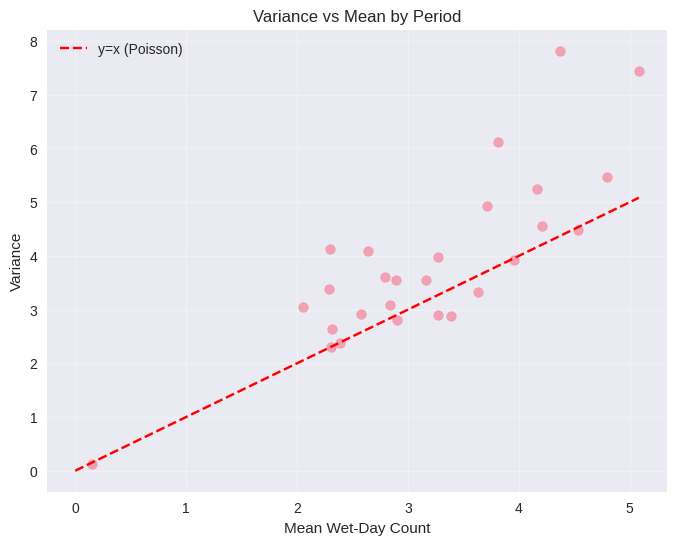

In [7]:
# Check Poisson assumptions
mean_count = wet_day_counts['wet_day_count'].mean()
var_count = wet_day_counts['wet_day_count'].var()
dispersion_ratio = var_count / mean_count

print(f"Mean wet-day count: {mean_count:.2f}")
print(f"Variance: {var_count:.2f}")
print(f"Dispersion ratio (variance/mean): {dispersion_ratio:.2f}")

if dispersion_ratio < 1.5:
    print("✓ Good: Variance ≈ mean (suitable for Poisson)")
elif dispersion_ratio < 3:
    print("⚠ Moderate overdispersion (Poisson may still work)")
else:
    print("✗ High overdispersion (consider NegativeBinomialGAM)")

# Plot variance vs mean by period
period_stats = wet_day_counts.groupby('period')['wet_day_count'].agg(['mean', 'var'])
period_stats = period_stats[period_stats['mean'] > 0]  # Remove periods with zero mean

plt.figure(figsize=(8, 6))
plt.scatter(period_stats['mean'], period_stats['var'], alpha=0.6)
plt.plot([0, period_stats['mean'].max()], [0, period_stats['mean'].max()], 
         'r--', label='y=x (Poisson)')
plt.xlabel('Mean Wet-Day Count')
plt.ylabel('Variance')
plt.title('Variance vs Mean by Period')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



In [8]:
# Prepare data for modeling: X (day of year) and y (wet-day count)
# Use period center as the predictor
wet_day_counts['period_center'] = (wet_day_counts['period'] - 1) * period_length + period_length / 2

# For modeling, we'll use day_of_year (1-365) as predictor
# Map period center back to approximate day of year
wet_day_counts['day_of_year_approx'] = wet_day_counts['period_center']

# Create X and y arrays for each year
model_data = {}
for year in wet_day_counts['year'].unique():
    year_data = wet_day_counts[wet_day_counts['year'] == year].sort_values('period')
    X = year_data[['day_of_year_approx']].values
    y = year_data['wet_day_count'].values
    model_data[year] = {'X': X, 'y': y, 'periods': year_data['period'].values}
    
print(f"Prepared data for {len(model_data)} years")
print(f"Sample year: {list(model_data.keys())[0]}")
print(f"  X shape: {model_data[list(model_data.keys())[0]]['X'].shape}")
print(f"  y shape: {model_data[list(model_data.keys())[0]]['y'].shape}")
print(f"  y range: {model_data[list(model_data.keys())[0]]['y'].min()} - {model_data[list(model_data.keys())[0]]['y'].max()}")



Prepared data for 73 years
Sample year: 1950
  X shape: (27, 1)
  y shape: (27,)
  y range: 0 - 6


## Section 5: Fit Model to Individual Years

### Spline Terms Explained

We'll use **spline terms** to model the smooth seasonal pattern:
- **n_splines=12**: 12 basis functions (monthly resolution)
- **spline_order=3**: Cubic splines (smooth curves)
- **s(0)**: Smooth spline on feature 0 (day of year)

The spline captures the non-linear relationship between day of year and expected wet-day count, allowing for smooth seasonal variations.

### Why Separate Models per Year?

- Captures year-specific seasonal patterns
- Allows comparison of year-to-year variability  
- More interpretable than pooled model with year interactions
- Handles potential non-stationarity in climate patterns


Year-to-year comparison:
 year   mean_y  mean_pred        AIC  deviance
 1950 2.555556   2.555556 102.312184 20.720899
 1951 3.888889   3.888889 104.917820  7.438263
 1952 3.074074   3.074074 105.115711 19.309555
 1953 3.185185   3.185185 108.012965 19.618314
 1954 2.296296   2.296296  98.497650 20.449606
 1955 2.962963   2.962963 109.751856 28.137237
 1956 2.481481   2.481481 105.668409 28.554165
 1957 3.740741   3.740741 118.242434 30.062067
 1958 3.666667   3.666667 122.235375 31.793679
 1959 3.259259   3.259259 109.658126 21.873238
 1960 2.851852   2.851852 121.926836 40.932307
 1961 3.851852   3.851852 119.869778 28.570219
 1962 2.962963   2.962963 121.631726 41.542726
 1963 2.777778   2.777778 115.180543 36.269000
 1964 2.888889   2.888889 117.336439 33.571223
 1965 3.814815   3.814815 122.682593 34.495159
 1966 3.148148   3.148148 115.345934 31.218783
 1967 3.962963   3.962963 119.576120 29.053527
 1968 2.925926   2.925926 107.551023 21.867085
 1969 3.592593   3.592593 121.06809

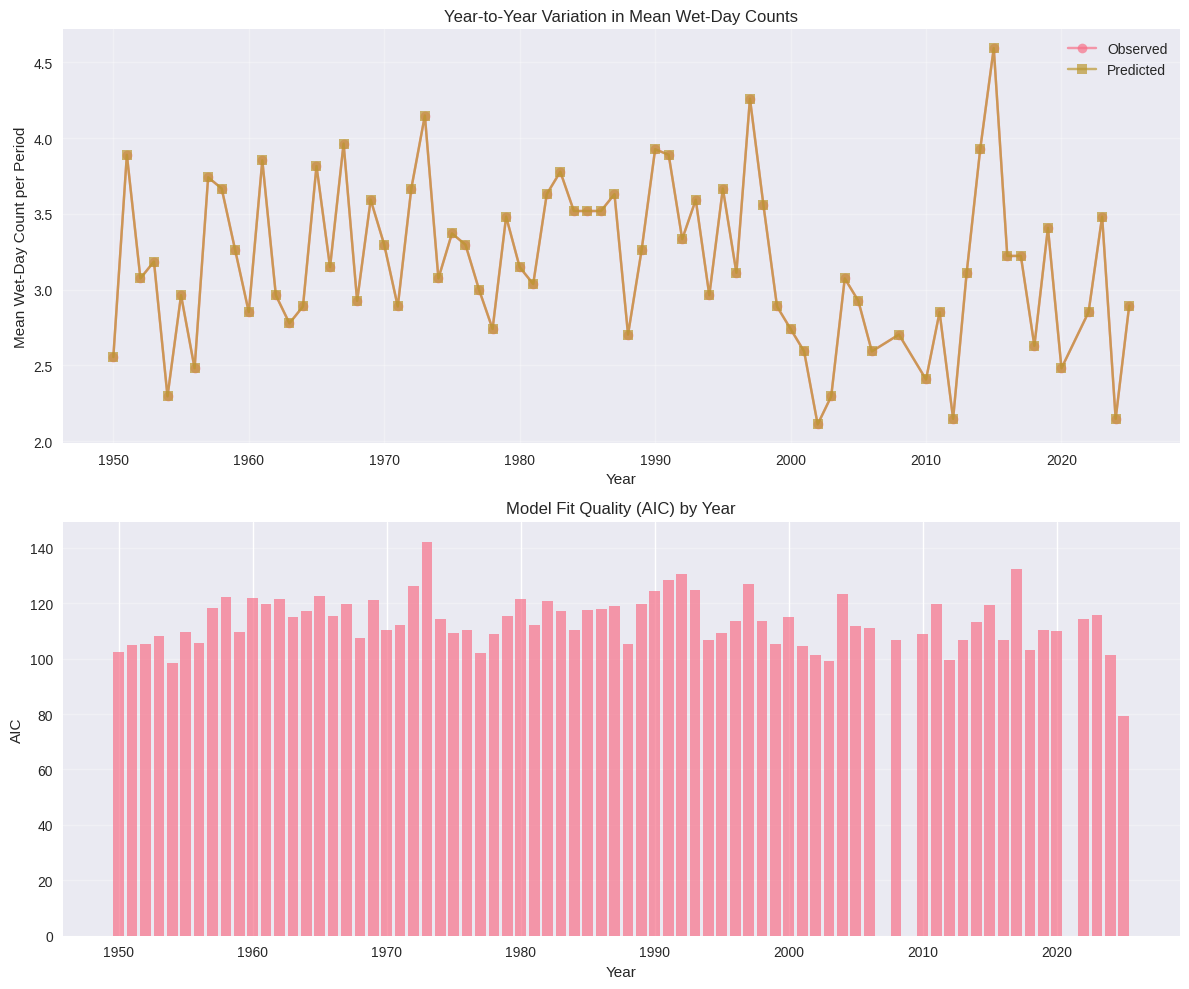

In [19]:
# Compare year-to-year variations
print("Year-to-year comparison:")
print(fit_summary_df[['year', 'mean_y', 'mean_pred', 'AIC', 'deviance']].to_string(index=False))

# Visualize year-to-year patterns
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot mean observed vs predicted by year
axes[0].plot(fit_summary_df['year'], fit_summary_df['mean_y'], 'o-', label='Observed', alpha=0.7)
axes[0].plot(fit_summary_df['year'], fit_summary_df['mean_pred'], 's-', label='Predicted', alpha=0.7)
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Mean Wet-Day Count per Period')
axes[0].set_title('Year-to-Year Variation in Mean Wet-Day Counts')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot AIC by year
axes[1].bar(fit_summary_df['year'], fit_summary_df['AIC'], alpha=0.7)
axes[1].set_xlabel('Year')
axes[1].set_ylabel('AIC')
axes[1].set_title('Model Fit Quality (AIC) by Year')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()



## Section 6: Model Diagnostics

We'll examine residuals, Q-Q plots, and prediction intervals to assess model fit and check assumptions.


In [11]:
# Residuals analysis for a sample year
sample_year = sorted(models.keys())[len(models) // 2]  # Middle year
gam = models[sample_year]
X = model_data[sample_year]['X']
y = model_data[sample_year]['y']

# Get predictions
y_pred = gam.predict(X)

# Calculate residuals
# Raw residuals
raw_residuals = y - y_pred

# Deviance residuals (more appropriate for Poisson)
# Deviance residual = sign(y - μ) * sqrt(2 * [y * log(y/μ) - (y - μ)])
mu = y_pred
with np.errstate(divide='ignore', invalid='ignore'):
    deviance_residuals = np.sign(y - mu) * np.sqrt(2 * (y * np.log(np.where(y > 0, y / (mu + 1e-10), 1)) - (y - mu)))

# Standardized residuals
std_residuals = deviance_residuals / np.std(deviance_residuals)

print(f"Residuals for year {sample_year}:")
print(f"  Raw residuals: mean={raw_residuals.mean():.3f}, std={raw_residuals.std():.3f}")
print(f"  Deviance residuals: mean={deviance_residuals.mean():.3f}, std={deviance_residuals.std():.3f}")



Residuals for year 1986:
  Raw residuals: mean=0.000, std=1.772
  Deviance residuals: mean=-0.145, std=1.051


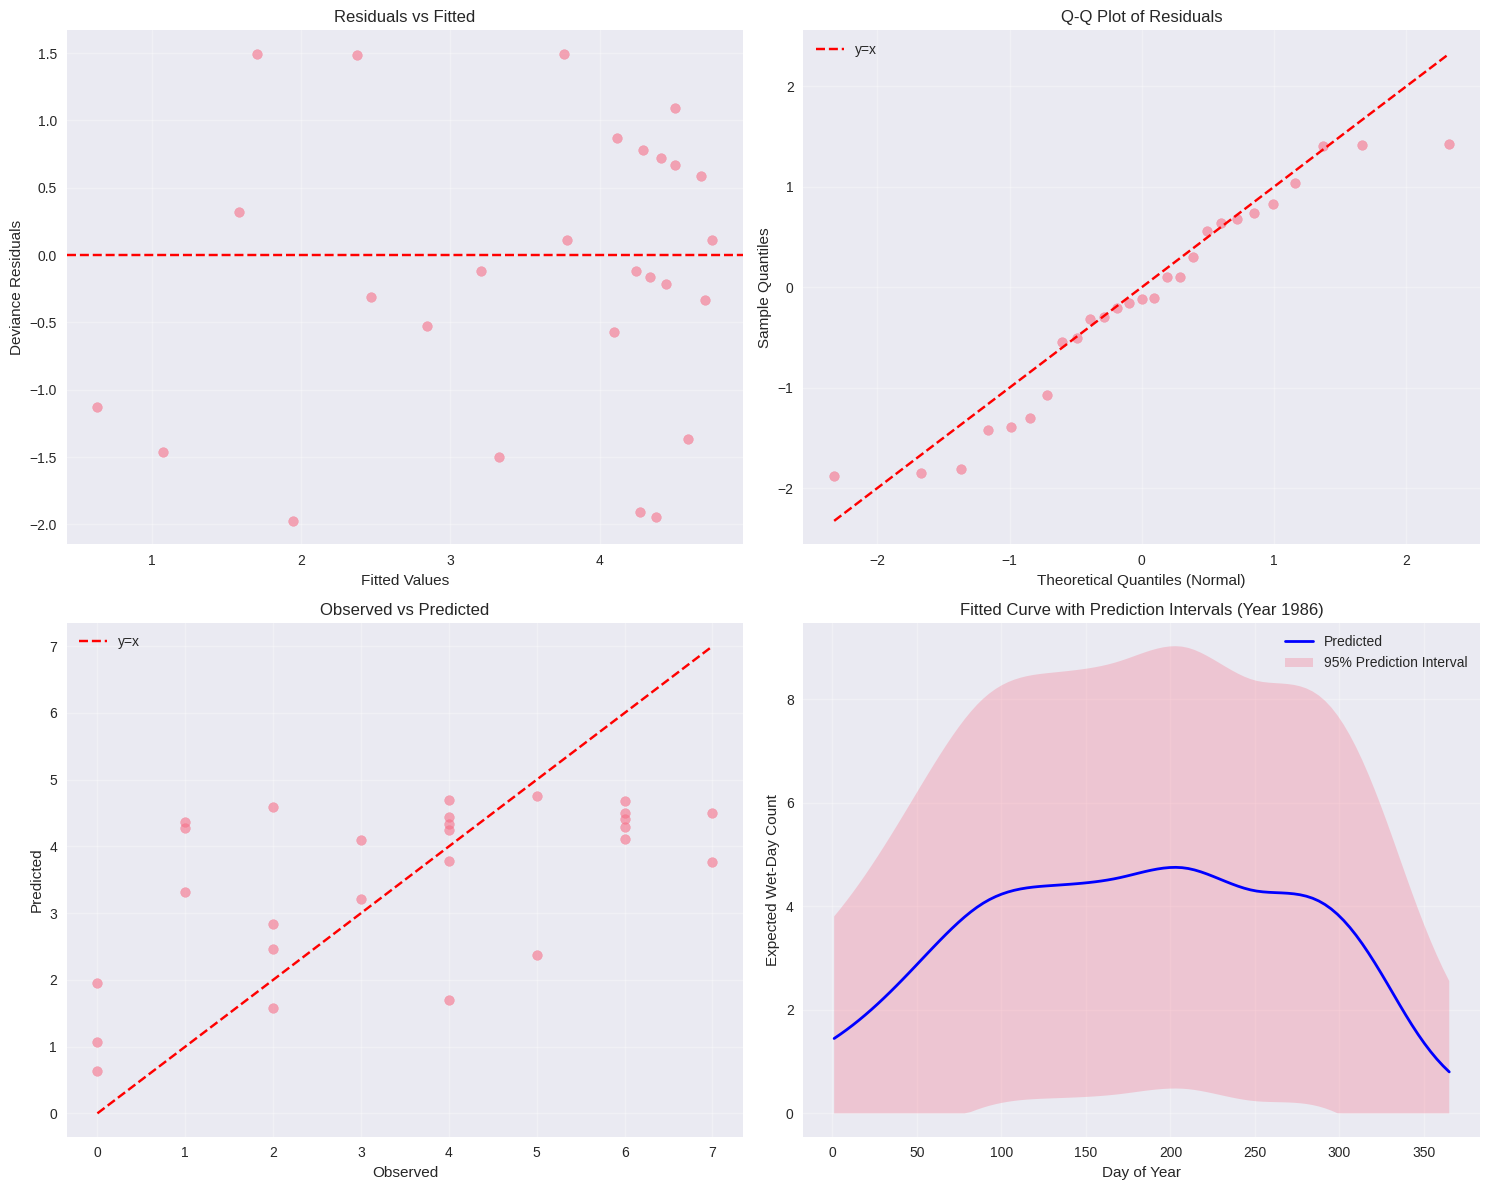


Model diagnostics for year 1986:
  R² (pseudo): 0.339
  AIC: 117.98


In [12]:
# Diagnostic plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Residuals vs fitted
axes[0, 0].scatter(y_pred, deviance_residuals, alpha=0.6)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Deviance Residuals')
axes[0, 0].set_title('Residuals vs Fitted')
axes[0, 0].grid(True, alpha=0.3)

# 2. Q-Q plot (compare to normal distribution)
from scipy.stats import norm
sorted_residuals = np.sort(std_residuals)
theoretical_quantiles = norm.ppf(np.linspace(0.01, 0.99, len(sorted_residuals)))
axes[0, 1].scatter(theoretical_quantiles, sorted_residuals, alpha=0.6)
axes[0, 1].plot([theoretical_quantiles.min(), theoretical_quantiles.max()],
                [theoretical_quantiles.min(), theoretical_quantiles.max()], 
                'r--', label='y=x')
axes[0, 1].set_xlabel('Theoretical Quantiles (Normal)')
axes[0, 1].set_ylabel('Sample Quantiles')
axes[0, 1].set_title('Q-Q Plot of Residuals')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Observed vs predicted
axes[1, 0].scatter(y, y_pred, alpha=0.6)
axes[1, 0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='y=x')
axes[1, 0].set_xlabel('Observed')
axes[1, 0].set_ylabel('Predicted')
axes[1, 0].set_title('Observed vs Predicted')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Prediction intervals (using confidence intervals)
# For Poisson, we can use prediction intervals based on the Poisson distribution
X_pred = np.linspace(1, 365, 100).reshape(-1, 1)
y_pred_smooth = gam.predict(X_pred)
# Get confidence intervals (approximate)
# Note: pygam doesn't directly provide prediction intervals for Poisson,
# but we can use the mean prediction as a guide
lower_bound = np.maximum(0, y_pred_smooth - 1.96 * np.sqrt(y_pred_smooth))
upper_bound = y_pred_smooth + 1.96 * np.sqrt(y_pred_smooth)

axes[1, 1].plot(X_pred, y_pred_smooth, 'b-', label='Predicted', linewidth=2)
axes[1, 1].fill_between(X_pred.flatten(), lower_bound, upper_bound, 
                        alpha=0.3, label='95% Prediction Interval')
axes[1, 1].set_xlabel('Day of Year')
axes[1, 1].set_ylabel('Expected Wet-Day Count')
axes[1, 1].set_title(f'Fitted Curve with Prediction Intervals (Year {sample_year})')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate deviance for pseudo R²
with np.errstate(divide='ignore', invalid='ignore'):
    deviance = 2 * np.sum(y * np.log(np.where(y > 0, y / (y_pred + 1e-10), 1)) - (y - y_pred))
    null_deviance = 2 * np.sum(y * np.log(np.where(y > 0, y / (y.mean() + 1e-10), 1)) - (y - y.mean()))

print(f"\nModel diagnostics for year {sample_year}:")
print(f"  R² (pseudo): {1 - deviance / null_deviance:.3f}")
print(f"  AIC: {gam.statistics_['AIC']:.2f}")



## Section 7: Visualization & Interpretation

### Interpreting Results

**Log Link Interpretation**:
- The model predicts log(μ) = f(day_of_year)
- On the log scale: f(day_of_year) shows the log-expected wet-day count
- Back-transformation: μ = exp(f(day_of_year)) gives the expected count
- A unit increase in f(day_of_year) corresponds to a multiplicative change in expected count

**Seasonal Patterns**:
- Peaks in the curve indicate periods with higher expected wet-day counts
- Troughs indicate drier periods
- The smoothness captures gradual seasonal transitions

**Year-to-Year Differences**:
- Comparing fitted curves across years reveals:
  - Consistent seasonal patterns (if present)
  - Inter-annual variability
  - Potential climate trends


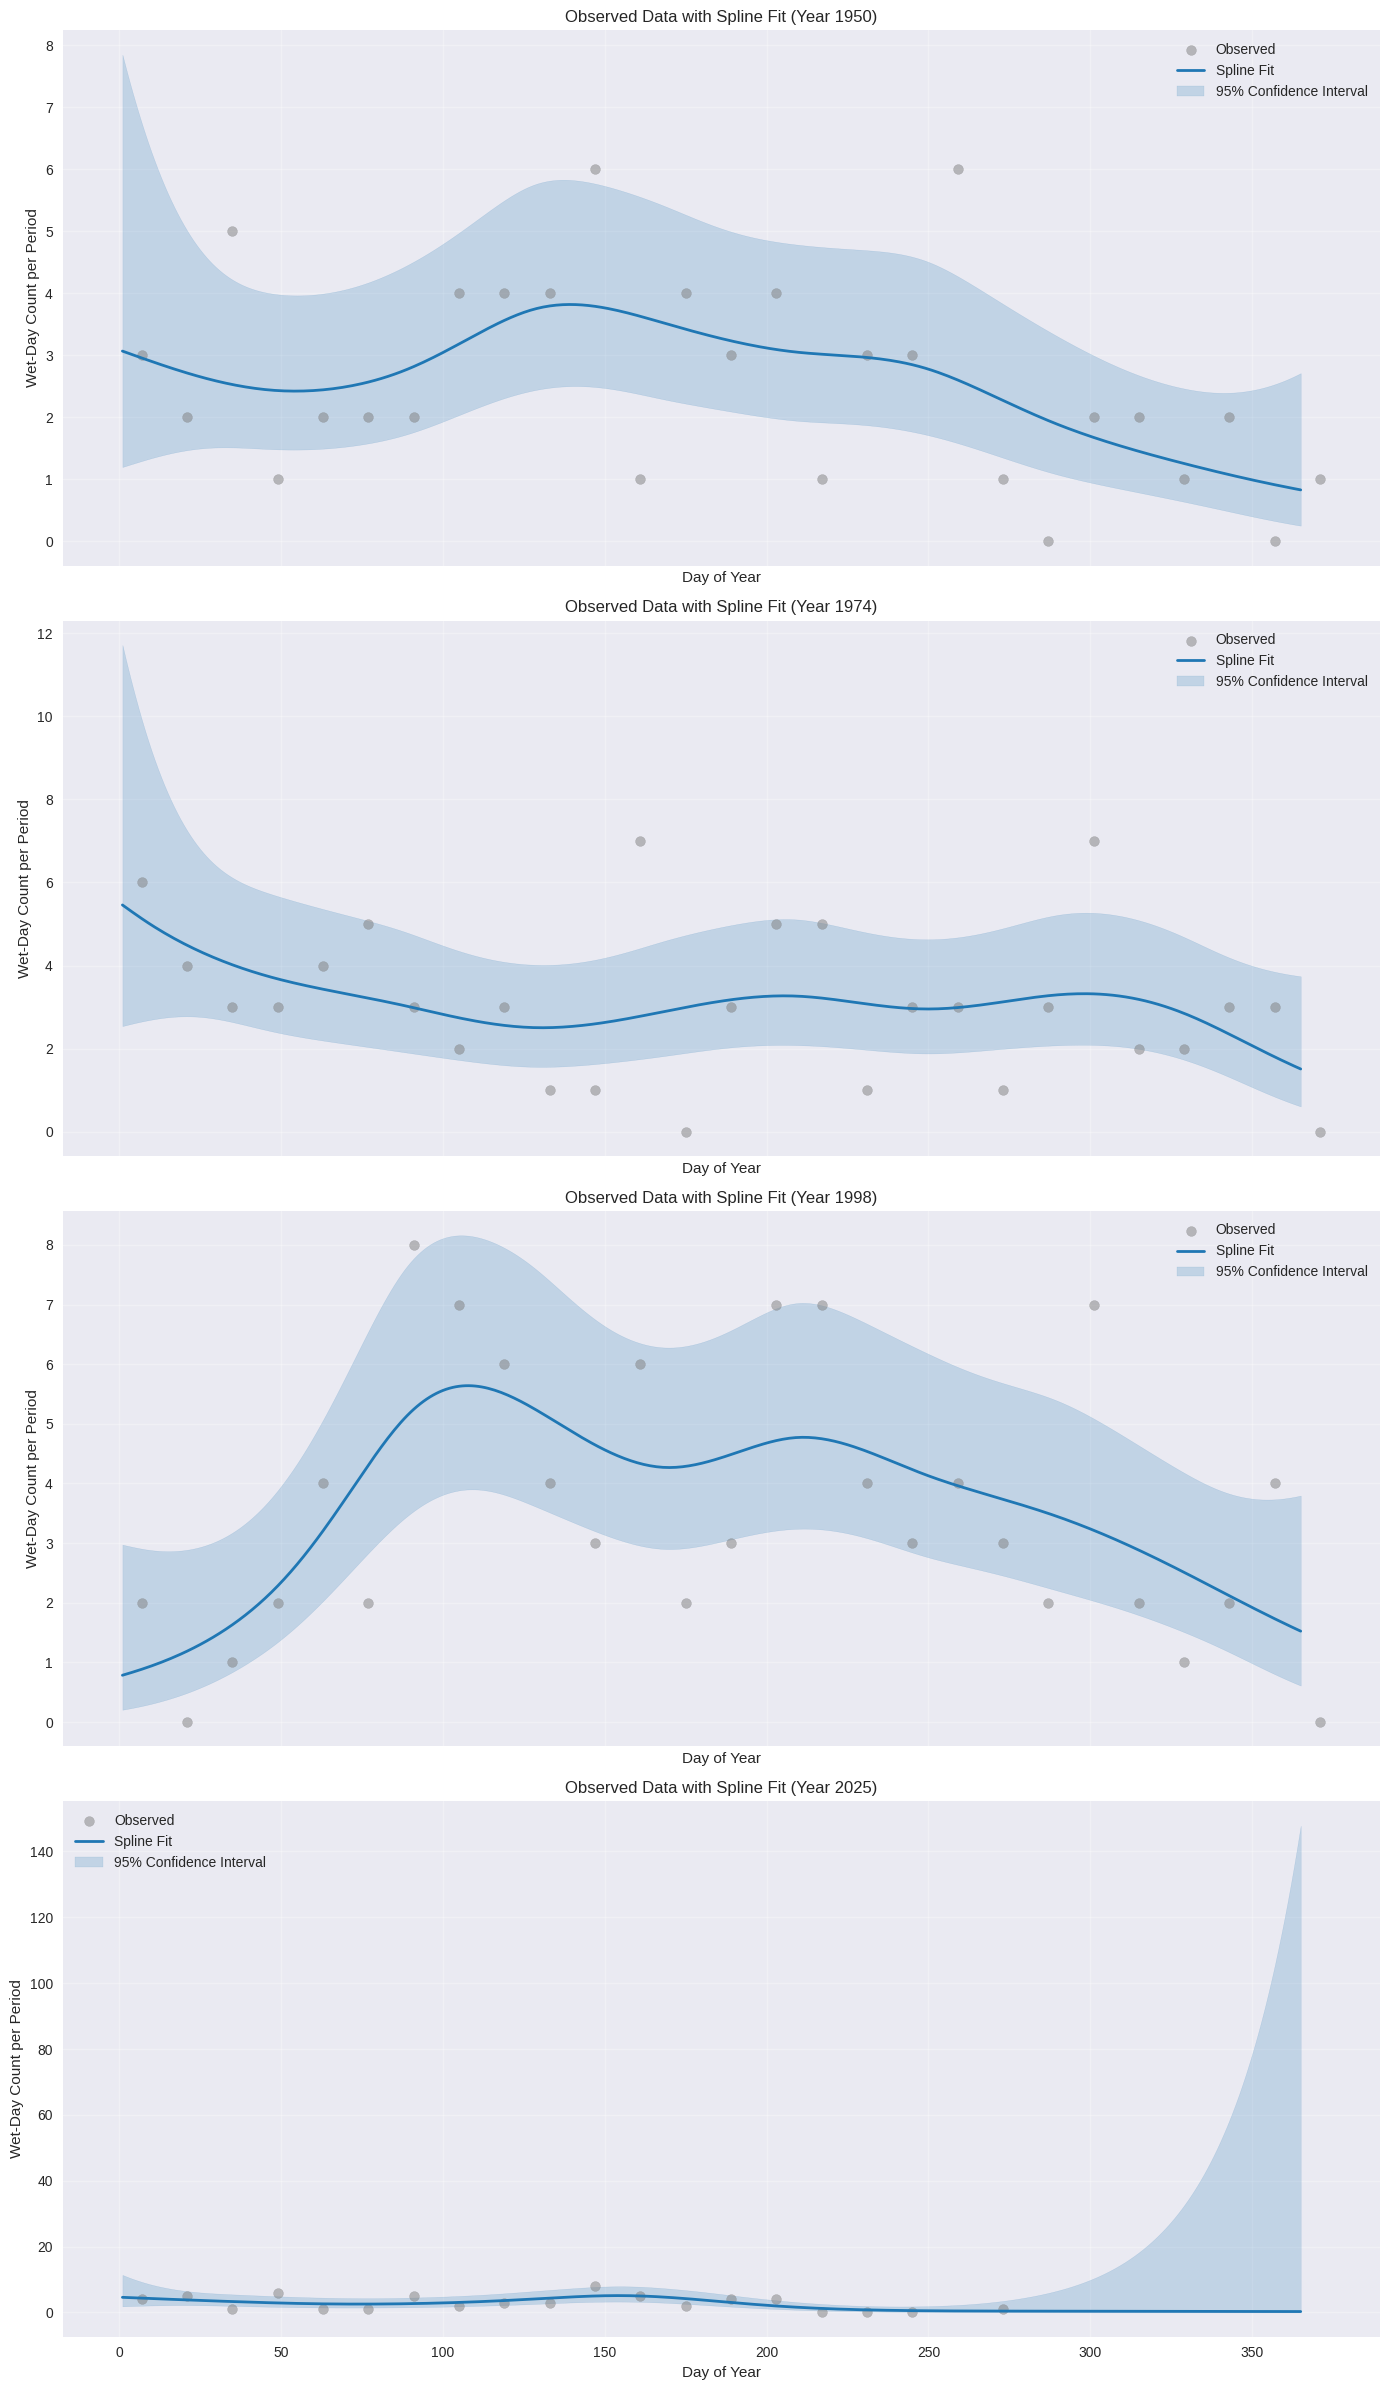

In [22]:
# Overlay original data with approximation using splines and show confidence intervals. One year per graph

# Choose a few representative years
years_to_plot = sorted(models.keys())[::max(1, len(models)//3)]  # Sample every 3rd year

n_years = len(years_to_plot)
fig, axes = plt.subplots(n_years, 1, figsize=(14, 6 * n_years), sharex=True)

if n_years == 1:
    axes = [axes]

for ax, year in zip(axes, years_to_plot):
    gam = models[year]
    year_data = wet_day_counts[wet_day_counts['year'] == year].sort_values('period')
    X_obs = year_data[['day_of_year_approx']].values
    y_obs = year_data['wet_day_count'].values

    # Predict spline fit and confidence intervals
    X_pred = np.linspace(1, 365, 365).reshape(-1, 1)
    y_pred = gam.predict(X_pred)
    
    # Get standard errors of predictions (pointwise)
    # Most pygam-like interfaces offer .prediction_intervals or .confidence_intervals
    # We'll compute using normal approximation: 95% CI as pred +- 1.96*SE
    # Confidence intervals are not a public utility in pygam.utils; use standard_errors directly

    if hasattr(gam, 'confidence_intervals'):
        pred_interval = gam.confidence_intervals(X_pred, width=0.95)
        lower_bound, upper_bound = pred_interval[:,0], pred_interval[:,1]
    else:
        # Fallback: normal approx using pointwise SE
        y_pred_se = gam.standard_errors(X_pred)
        lower_bound = y_pred - 1.96 * y_pred_se
        upper_bound = y_pred + 1.96 * y_pred_se

    # Ensure CI non-negative for counts
    lower_bound = np.maximum(0, lower_bound)

    # Plot observed data (scatter)
    ax.scatter(X_obs, y_obs, alpha=0.5, s=50, label='Observed', color='tab:gray', zorder=2)
    # Plot spline approximation (curve)
    ax.plot(X_pred, y_pred, color='tab:blue', linewidth=2, label='Spline Fit', zorder=3)
    # Plot confidence interval as filled area
    ax.fill_between(X_pred.flatten(), lower_bound, upper_bound, color='tab:blue', alpha=0.2, label='95% Confidence Interval', zorder=1)

    ax.set_xlabel('Day of Year')
    ax.set_ylabel('Wet-Day Count per Period')
    ax.set_title(f'Observed Data with Spline Fit (Year {year})')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
plt.tight_layout()
plt.show()


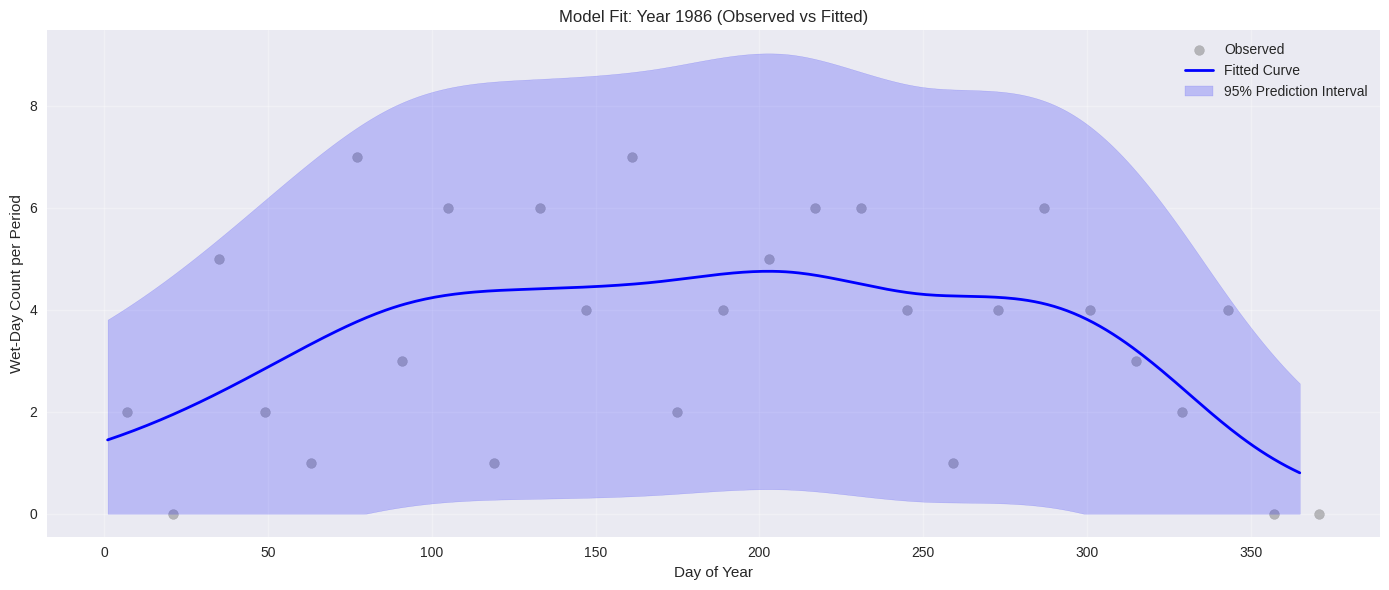


Interpretation for year 1986:
  Peak wet-day count: 4.75 (day 203)
  Minimum wet-day count: 0.80 (day 365)
  Range: 3.95


In [14]:
# Detailed comparison: overlay observed data with fitted curves for one year
comparison_year = sorted(models.keys())[len(models) // 2]
gam = models[comparison_year]
year_data = wet_day_counts[wet_day_counts['year'] == comparison_year].sort_values('period')

X_obs = year_data[['day_of_year_approx']].values
y_obs = year_data['wet_day_count'].values
y_pred_obs = gam.predict(X_obs)

# Smooth prediction
X_pred = np.linspace(1, 365, 365).reshape(-1, 1)
y_pred_smooth = gam.predict(X_pred)

fig, axes = plt.subplots(1, 1, figsize=(14, 6))

# Plot observed data
axes.scatter(X_obs, y_obs, alpha=0.5, s=50, label='Observed', color='gray')

# Plot fitted curve
axes.plot(X_pred, y_pred_smooth, 'b-', linewidth=2, label='Fitted Curve')

# Add prediction intervals
lower_bound = np.maximum(0, y_pred_smooth - 1.96 * np.sqrt(y_pred_smooth))
upper_bound = y_pred_smooth + 1.96 * np.sqrt(y_pred_smooth)
axes.fill_between(X_pred.flatten(), lower_bound, upper_bound, 
                  alpha=0.2, label='95% Prediction Interval', color='blue')

axes.set_xlabel('Day of Year')
axes.set_ylabel('Wet-Day Count per Period')
axes.set_title(f'Model Fit: Year {comparison_year} (Observed vs Fitted)')
axes.legend()
axes.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nInterpretation for year {comparison_year}:")
print(f"  Peak wet-day count: {y_pred_smooth.max():.2f} (day {X_pred[np.argmax(y_pred_smooth)][0]:.0f})")
print(f"  Minimum wet-day count: {y_pred_smooth.min():.2f} (day {X_pred[np.argmin(y_pred_smooth)][0]:.0f})")
print(f"  Range: {y_pred_smooth.max() - y_pred_smooth.min():.2f}")



### When is PoissonGAM Appropriate vs Alternatives?

**PoissonGAM is appropriate when**:
- ✓ Outcome is count data (non-negative integers)
- ✓ Mean and variance are approximately equal
- ✓ Zero-inflation is moderate
- ✓ You want to model seasonal/cyclical patterns smoothly

**Consider alternatives when**:
- **Overdispersion (variance >> mean)**: Use NegativeBinomialGAM
- **Continuous amounts**: Use GammaGAM or LinearGAM
- **Zero-inflation severe**: Use Zero-Inflated Poisson or hurdle models
- **Binary outcomes**: Use LogisticGAM

**Key Takeaways**:
1. PoissonGAM effectively captures smooth seasonal patterns in count data
2. Log link ensures positive predictions and interpretable multiplicative effects
3. Spline terms provide flexibility to model complex non-linear relationships
4. Separate models per year allow for year-to-year comparison while maintaining interpretability
5. Model diagnostics help validate assumptions and assess fit quality

